In [47]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import random
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Loading data from S3

In [48]:
# s3_uri = "s3://aws-athena-query-results-378141045805-eu-west-1/primary/e28fee6c-ad6a-429f-9a52-8dff2c0481c3.csv"

In [49]:
# Path to the local data
# The variable name is kept unchanged for future references
s3_uri = "../data/smart-climate-2021/c096aced-8c13-4a71-9499-641f559ddf08.csv"

In [50]:
climate_data_2021 = pd.read_csv(s3_uri)
climate_data_2021.shape

(2539685, 69)

In [5]:
# total number of cars
print(climate_data_2021['c_van17'].nunique())

# total number of drives
print(climate_data_2021['c_driveid'].nunique())

# number of drives per car
print(climate_data_2021.groupby(['c_van17'])['c_driveid'].nunique().min(), climate_data_2021.groupby(['c_van17'])['c_driveid'].nunique().mean(), climate_data_2021.groupby(['c_van17'])['c_driveid'].nunique().max())

# min and max events per drive
print(climate_data_2021['c_driveid'].value_counts().min(), climate_data_2021['c_driveid'].value_counts().mean(), climate_data_2021['c_driveid'].value_counts().max())

23843
238803
5 10.015644004529632 430
6 10.635063211098688 99


In [24]:
# Let's see the data types
data_types = climate_data_2021.dtypes.unique()
for dtype in data_types:
    print(f"{dtype}: {(climate_data_2021.dtypes == dtype).sum()}")

object: 33
float64: 24
int64: 8
bool: 4


### Curate the dataset
1. delete the drives which had only temperatures 16 and 28
2. delete the events where there was no change in the temp (not yet)
3. delet the events with 0 second duration

### First sort the dataset with c_van17, c_driveid and c_msg_creation_timestamp

In [28]:
# Sorting the dataset with c_driveid and c_msg_creation_timestamp ascendingly
climate_data_2021.sort_values(['c_van17', 'c_driveid', 'c_msg_creation_timestamp'], inplace=True)

#### Delete non-relevant columns

In [30]:
not_relevant_columns = [
    'c_min_diff_ms_blower_level',
    'c_min_diff_ms_blower_style',
    'c_min_diff_ms_air_dist',
    'c_min_diff_ms_auto_mode',
    'c_min_diff_ms_target_temp',
    'c_interiortemperature_startup_celsius',
    'c_vehicle_live_time_days',
    'c_gpsregion_geohash_drive',
    'c_gps_data_source',
    'c_hub',
    'c_country_iso_code',
    'c_hybridkennzeichen',
    'c_bcbehvenergystart_kwh',
    'c_bcbehvenergyend_kwh',
    'c_touchscreen_used_count',
    'c_first_last_mode',
    # 'c_auto_mode',
    # 'c_pwf',
]

In [31]:
climate_data_2021 = climate_data_2021.drop(columns = not_relevant_columns)
climate_data_2021.shape

(2539685, 53)

In [32]:
# Let's see the data types
data_types = climate_data_2021.dtypes.unique()
for dtype in data_types:
    print(f"{dtype}: {(climate_data_2021.dtypes == dtype).sum()}")

object: 27
float64: 15
int64: 7
bool: 4


### Dealing with missing values

#### Delete columns with missing values

In [34]:
missing_vals_check = climate_data_2021.isna().sum()
missing_val_feature_and_count = missing_vals_check[missing_vals_check>0]
missing_val_cols = missing_val_feature_and_count.keys().tolist()
missing_val_cols, missing_val_feature_and_count

(['c_min_exteriortemperature_celsius',
  'c_exteriortemperature_avg_celsius',
  'c_max_exteriortemperature_celsius',
  'c_timezonedelta',
  'c_gpsregion_city_drive',
  'c_gpsregion_lat_drive',
  'c_gpsregion_long_drive'],
 c_min_exteriortemperature_celsius        22
 c_exteriortemperature_avg_celsius        22
 c_max_exteriortemperature_celsius        22
 c_timezonedelta                      334084
 c_gpsregion_city_drive               213298
 c_gpsregion_lat_drive                294594
 c_gpsregion_long_drive               294594
 dtype: int64)

In [36]:
# Delete rows with missing values
climate_data_2021 = climate_data_2021.dropna(subset=['c_min_exteriortemperature_celsius', 'c_exteriortemperature_avg_celsius', 'c_max_exteriortemperature_celsius'])
climate_data_2021.shape

(2539663, 53)

In [38]:
missing_val_cols = [
  'c_timezonedelta',
  'c_gpsregion_city_drive',
  'c_gpsregion_lat_drive',
  'c_gpsregion_long_drive']

In [39]:
# Drop the columns with missing values
climate_data_2021 = climate_data_2021.drop(missing_val_cols, axis=1)
print(climate_data_2021.isna().sum())
climate_data_2021.shape

c_van17                              0
c_driveid                            0
c_drive_timestamp_start              0
c_drive_timestamp_stop               0
c_msg_creation_timestamp             0
c_target_temp                        0
c_blower_combined                    0
c_air_mode_combined                  0
c_blower_level                       0
c_blower_style                       0
c_air_dist                           0
c_auto_mode                          0
c_pwf                                0
c_pwf_group                          0
c_row_number_drive                   0
c_number_of_rows_drive               0
c_only_driving_duration_sec          0
c_event_duration_sec                 0
c_min_exteriortemperature_celsius    0
c_exteriortemperature_avg_celsius    0
c_max_exteriortemperature_celsius    0
c_drive_duration_sec                 0
c_drive_duration_minutes             0
c_drive_weekday                      0
c_year_month_day                     0
c_weekofyear_year        

(2539663, 49)

### Choose only those instances where the vehcile was in FAHREN mode

In [40]:
climate_data_2021 = climate_data_2021[climate_data_2021['c_pwf_group'] == 'FAHREN']
climate_data_2021.shape

(2539663, 49)

#### Delete the events with 0 seconds duration

In [41]:
climate_data_2021 = climate_data_2021[~(climate_data_2021['c_event_duration_sec'] == 0)]
climate_data_2021.shape

(2520827, 49)

In [42]:
climate_data_2021['c_event_duration_sec'].mean(), climate_data_2021['c_event_duration_sec'].median(), climate_data_2021['c_event_duration_sec'].std()

(531.2559287091101, 229.0, 809.763147902246)

#### Delete the drives where the temperature didn't change at all.

In [43]:
# # Check across how many drives the temperature didn't change at all
# # Check across how many drives the temperature didn't change at all
# climate_data_2021['d_diff_in_target_temp'] = climate_data_2021.sort_values(['c_driveid', 'c_msg_creation_timestamp']).groupby('c_driveid')['c_target_temp'].diff()
# climate_data_2021.shape

In [44]:
# drive_wise_temp_change = (climate_data_2021.groupby('c_driveid')['d_diff_in_target_temp'].agg(lambda x: abs(x).sum()) == 0.0)
# print(drive_wise_temp_change.sum())

# drive_wise_temp_change = (climate_data_2021.groupby('c_driveid')['d_diff_in_target_temp'].agg(lambda x: abs(x).sum()) == 0.0)
# drive_ids_with_no_temp_change = drive_wise_temp_change[drive_wise_temp_change == True].index.tolist()
# df_with_no_temp_change = climate_data_2021[climate_data_2021['c_driveid'].isin(drive_ids_with_no_temp_change)]
# climate_data_2021 = climate_data_2021[~climate_data_2021['c_driveid'].isin(drive_ids_with_no_temp_change)]
# climate_data_2021.shape

In [45]:
# (climate_data_2021.groupby('c_driveid')['d_diff_in_target_temp'].agg(lambda x: abs(x).sum()) == 0.0).sum()

### See the distribution of target_temp

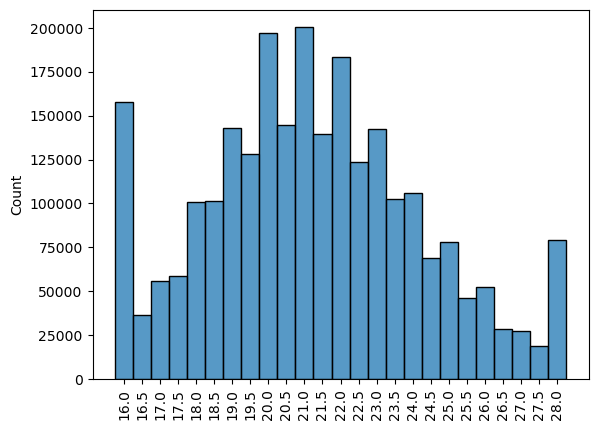

In [46]:
# ticks = np.arange(16, 28.5, 0.5)
target_temps = sorted([str(temp) for temp in climate_data_2021['c_target_temp']])
sns.histplot(target_temps)
# plt.xticks(ticks)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# How many temperature values are there
len(sorted(climate_data_2021['c_target_temp'].unique()))

#### Deletion continues

In [ ]:
climate_data_2021_non_contextual = climate_data_2021.copy()

In [ ]:
columns_to_drop_while_training = [
    'c_drive_duration_minutes',
    'c_number_of_rows_drive',
    'c_event_duration_sec',
    'c_year_month_day',
    'c_row_number_drive',
    'c_weekofyear_year',
    'c_avg_drives_per_day',
    'c_avg_drives_per_week',
    'c_avg_drives_per_month',
    'c_mileage_start',
    'c_mileage_stop',
    'c_mileage_delta',
    'c_drive_number_per_car',
    'c_number_of_drives_per_car',
    # 'd_diff_in_target_temp',
    'c_only_driving_duration_sec',
    'c_drive_timestamp_stop',
    'c_min_exteriortemperature_celsius',
    'c_max_exteriortemperature_celsius',
    # 'c_exteriortemperature_avg_celsius',
    'c_drive_duration_sec',
    # 'c_touchscreen_used_count',
    'c_mean_speed',
]

In [ ]:
climate_data_2021.drop(columns_to_drop_while_training, axis= 1, inplace=True)
climate_data_2021.shape

In [ ]:
numerical_columns = climate_data_2021.select_dtypes(include='number').columns
correlation_matrix = climate_data_2021[numerical_columns].corr().abs()
# print(correlation_matrix)
sns.heatmap(correlation_matrix, cmap='Greens')
# correlation_matrix

In [ ]:
climate_data_2021.dtypes

In [ ]:
numerical_columns = climate_data_2021.select_dtypes(include='number').columns
numerical_columns.shape

### Preprocessing of the features

In [ ]:
# # Use binnning

# # Define temperature range bins
# temp_bins = [16, 18, 20, 22, 24, 26, 29]

# # Use pd.cut() function to create temperature range feature
# climate_data_2021['d_target_temp_range'] = pd.cut(climate_data_2021['c_target_temp'], bins=temp_bins, labels=[f'{x}-{x+2}' for x in temp_bins[:-1]], right=False)

# # Print the updated dataframe
# climate_data_2021[['c_target_temp', 'd_target_temp_range']]

#### One-hot encode the categorical features

In [ ]:
categorical_columns = climate_data_2021.select_dtypes(include=['object']).columns.tolist()
cat_cols_excluded = ['c_van17', 'c_driveid', 'c_drive_timestamp_start', 'c_msg_creation_timestamp']
for cat_col in cat_cols_excluded:
    categorical_columns.remove(cat_col)
one_hot_cols = categorical_columns
len(one_hot_cols)

In [ ]:
for cat_col in sorted(categorical_columns):
    print(f"{cat_col}({climate_data_2021[cat_col].nunique()}){'-'*10}> {sorted(climate_data_2021[cat_col].unique())}")

In [ ]:
more_cols_to_drop = [
    'c_derivat',
    'c_brand',
    'c_order_country',
    'c_marketing_name',
    'c_steering_wheel_position',
    'c_product_line',
    'c_fuel_type_corrected_description',
    'c_vehicle_class',
    'c_script_version',
    'c_gcad',
    # 'c_air_dist',
    'c_blower_combined',
    # 'c_blower_style',
    # 'c_blower_level',
    'c_pwf',
    # 'c_air_mode_combined',
    'c_is_guest_profile',
    'c_is_active_profile',
    # 'c_auto_mode',
    'c_weekend_drive',
    'c_touchscreen_used',
    'c_drive_weekday',
    'c_pwf_group',
]

In [ ]:
climate_data_2021.drop(more_cols_to_drop, axis=1, inplace=True)
climate_data_2021.shape

In [ ]:
contextual_features = climate_data_2021.columns

In [ ]:
categorical_columns = climate_data_2021.select_dtypes(include=['object']).columns.tolist()
cat_cols_excluded = ['c_van17', 'c_driveid', 'c_drive_timestamp_start', 'c_msg_creation_timestamp']
for cat_col in cat_cols_excluded:
    categorical_columns.remove(cat_col)
one_hot_cols = categorical_columns
len(one_hot_cols)

In [ ]:
climate_data_2021[one_hot_cols].head()

In [ ]:
climate_data_2021 = pd.get_dummies(climate_data_2021, columns=one_hot_cols)
climate_data_2021.shape

##### Convert the bool cols to int 0/1

In [ ]:
bool_columns = climate_data_2021.select_dtypes(include=['bool']).columns
climate_data_2021[bool_columns] = climate_data_2021[bool_columns].astype('int')
climate_data_2021.shape

In [ ]:
target_temps = sorted(np.array([str(temp) for temp in climate_data_2021['c_target_temp']]))
sns.histplot(target_temps)
plt.xticks(rotation=90)
plt.show()

### Now fill the events at a certain interval

##### Average event duration is 351 seconds with a very high STD of 721
The median is 88 seconds (subject to change of the dataset being used)

In [ ]:
climate_data_2021 = climate_data_2021.sort_values(['c_driveid', 'c_msg_creation_timestamp'])

In [ ]:
# Distribution of the first temp of the drives
sns.histplot(climate_data_2021.groupby('c_driveid').first()['c_target_temp'], bins=25)

In [ ]:
climate_data_2021['c_msg_creation_timestamp'] = pd.to_datetime(climate_data_2021['c_msg_creation_timestamp'])

In [ ]:
# selected_time_interval = 300 # seconds

In [ ]:
# Filling

# from datetime import datetime, timedelta
# # Initialize an empty list to store new rows
# new_rows = []

# # Function to calculate new timestamps at 10-second intervals
# def generate_new_timestamps(row, next_row):
#     time_diff = (next_row['c_msg_creation_timestamp'] - row['c_msg_creation_timestamp']).total_seconds()
#     # print(f"time difference between subsequent rows: {time_diff}")
#     num_intervals = int(time_diff / selected_time_interval)
#     new_timestamps = [row['c_msg_creation_timestamp'] + timedelta(seconds=selected_time_interval * i) for i in range(1, num_intervals)]
    
#     # Ensure new timestamps do not exceed the next event's timestamp
#     new_timestamps = [ts for ts in new_timestamps if ts < next_row['c_msg_creation_timestamp']]
#     return new_timestamps

In [ ]:
# chosen_driveid = climate_data_2021['c_driveid'].unique()[0]
# climate_data_2021[climate_data_2021['c_driveid'] == chosen_driveid]

In [ ]:
# from tqdm import tqdm
# # Iterate through groups (each group is a visit)
# for _, group in tqdm(climate_data_2021.groupby('c_driveid')):
#     group = group.reset_index(drop=True)
    
#     # Iterate through the rows within the group to fill gaps
#     for i in range(len(group) - 1):
#         current_row = group.iloc[i]
#         next_row = group.iloc[i + 1]
        
#         new_rows.append(current_row.to_dict())
        
#         # Generate new timestamps at 10-second intervals
#         new_timestamps = generate_new_timestamps(current_row, next_row)
#         for new_timestamp in new_timestamps:
#             new_row = current_row.copy()
#             new_row['c_msg_creation_timestamp'] = new_timestamp
#             new_rows.append(new_row.to_dict())
    
#     # Add the last row in the group
#     new_rows.append(group.iloc[-1].to_dict())

In [ ]:
# len(new_rows)

In [ ]:
# import pickle

# with open('../data/climate_data_2021_only_fahren_3571_drives_only_climate_features_and_temp_change_at_each_step_events_at_180_seconds_interval.pkl', 'wb') as f:
#     pickle.dump(new_rows, f)

In [ ]:
# import pickle

# with open('../data/climate_data_2021_with_filled_events_at_60_seconds_interval.pkl', 'rb') as f:
#     new_rows = pickle.load(f)

In [ ]:
# # Create a new dataframe with the filled gaps
# climate_data_2021 = pd.DataFrame(new_rows)

# # print(new_df)
# climate_data_2021.shape

In [ ]:
# climate_data_2021.to_csv(f'../data/climate_data_2021_only_fahren_3571_drives_only_climate_features_events_at_180_seconds_interval.csv')

### Feature creation

#### Personalized features using VAE

In [ ]:
non_contextual_features = [
    # 'c_drive_duration_minutes',
    'c_van17',
    'c_driveid',
    'c_drive_timestamp_start',
    'c_msg_creation_timestamp',
    'c_number_of_rows_drive',
    'c_event_duration_sec',
    #  'c_year_month_day',
    #  'c_row_number_drive',
    'c_weekofyear_year',
    'c_avg_drives_per_day',
    #  'c_avg_drives_per_week',
    #  'c_avg_drives_per_month',
    'c_mileage_start',
    #  'c_mileage_stop',
    'c_mileage_delta',
    'c_drive_number_per_car',
    'c_number_of_drives_per_car',
    'c_only_driving_duration_sec',
    #  'c_drive_timestamp_stop',
    #  'c_min_exteriortemperature_celsius',
    #  'c_max_exteriortemperature_celsius',
    #  'c_drive_duration_sec',
    'c_mean_speed',
    'c_derivat',
    #  'c_brand',
    'c_order_country',
    'c_marketing_name',
    'c_steering_wheel_position',
    'c_product_line',
    'c_fuel_type_corrected_description',
    'c_vehicle_class',
    #  'c_script_version',
    'c_gcad',
    #  'c_blower_combined',
    #  'c_pwf',
    'c_is_guest_profile',
    'c_is_active_profile',
    #  'c_weekend_drive',
    'c_touchscreen_used',
    'c_drive_weekday',
    #  'c_pwf_group',
 ]
len(non_contextual_features)

In [ ]:
climate_data_2021_non_contextual = climate_data_2021_non_contextual[non_contextual_features]
climate_data_2021_non_contextual

In [ ]:
a_van_id = climate_data_2021_non_contextual['c_van17'].unique()[0]
climate_data_2021_non_contextual[climate_data_2021_non_contextual['c_van17'] == a_van_id]

In [ ]:
climate_data_2021_non_contextual['c_weekofyear'] = climate_data_2021_non_contextual['c_weekofyear_year'].apply(lambda x: x.split('_')[0])

climate_data_2021_non_contextual['c_weekofyear'] = climate_data_2021_non_contextual['c_weekofyear'].astype('uint8')
climate_data_2021_non_contextual.drop('c_weekofyear_year', axis=1, inplace=True)

In [ ]:
climate_data_2021_non_contextual['c_marketing_name'] = climate_data_2021_non_contextual['c_marketing_name'].apply(lambda x: x.lower())

##### VAE

In [ ]:
# sort the dataset according to timestamp and also drive_number
climate_data_2021_non_contextual = climate_data_2021_non_contextual.sort_values(by=['c_van17', 'c_driveid', 'c_drive_number_per_car'])

In [ ]:
categorical_columns = climate_data_2021_non_contextual.select_dtypes(include=['object']).columns.tolist()
cat_cols_excluded = ['c_van17', 'c_driveid', 'c_drive_timestamp_start', 'c_msg_creation_timestamp']
for cat_col in cat_cols_excluded:
    categorical_columns.remove(cat_col)
one_hot_cols = categorical_columns
len(one_hot_cols)


In [ ]:
climate_data_2021_non_contextual[one_hot_cols]

In [ ]:
climate_data_2021_non_contextual = pd.get_dummies(climate_data_2021_non_contextual, columns=one_hot_cols)
climate_data_2021_non_contextual.shape

In [ ]:
# Convert the bool cols into 0/1 values
bool_columns = climate_data_2021_non_contextual.select_dtypes(include=['bool']).columns
climate_data_2021_non_contextual[bool_columns] = climate_data_2021_non_contextual[bool_columns].astype('int')
climate_data_2021_non_contextual.shape

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import torch.optim as optim
import time
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os
# import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

#### VAE - second approach

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, z):
        reconstructed_x = self.decoder(z)
        return reconstructed_x
    
    
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(input_dim, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar
    
# Define the loss function (ELBO loss)
def loss_function(reconstructed_x, x, mu, logvar):
    # BCE = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')  # For binary data
    MSE = nn.functional.mse_loss(reconstructed_x, x)  # For real-valued data
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
def train_vae(vae, train_loader, optimizer, epochs):
   start = time.time()
   vae.train()
#    losses = []
   for epoch in range(epochs):
      for batch_idx, data in enumerate(train_loader):
         # print(data.shape)
         data = data.to('cpu')  # Move data to the device (e.g., GPU)
         optimizer.zero_grad()
         reconstructed_x, mu, logvar = vae(data)
         loss = loss_function(reconstructed_x, data, mu, logvar)
         loss.backward()
         optimizer.step()
        #  losses.append(loss.cpu().item())
         # if batch_idx % 100 == 0:
         #       print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")
   end = time.time()
   # print(f"time required: {(end-start):.2f} seconds")

### Produce vehicle specific embeddings using VAE

In [ ]:
orig_vid_to_custom_vid = {}
custom_vid_to_orig_vid = {}

van_ids = climate_data_2021_non_contextual['c_van17'].unique()

for (i, vid) in enumerate(van_ids):
    orig_vid_to_custom_vid[vid] = f"van_{i}"
    custom_vid_to_orig_vid[f"van_{i}"] = vid

In [ ]:
groups = climate_data_2021_non_contextual.groupby('c_van17')
latent_dim = 32
learning_rate = 1e-3
batch_size = 64

model_save_path = "/home/q621464/Desktop/Thesis/code/mlp-master-thesis-personalization/personalized-smart-climate/models"
vehicle_specific_embeddings = {}
for group_id, group_df in tqdm(groups):
   van_id = group_df['c_van17'].unique()[0]
   custom_vid = orig_vid_to_custom_vid[van_id]
   
   observations_df = group_df.drop(['c_driveid', 'c_van17', 'c_msg_creation_timestamp', 'c_drive_timestamp_start'], axis=1).astype('float32')
   observations = torch.from_numpy(observations_df.values)
   van_data = observations
   
   # Scale the datapoints
   scaler = StandardScaler()
   scaled_data = scaler.fit_transform(van_data).astype('float32')
   
   # Instantiate the VAE
   input_dim = scaled_data.shape[1]
   vae = VAE(input_dim, latent_dim)
   optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
   
   # Training loop
   train_loader = DataLoader(scaled_data, batch_size=batch_size, shuffle=True)
   train_vae(vae, train_loader, optimizer, 10)
   
   # Store the vehicle specific vae model
   torch.save(vae.state_dict(), f"{model_save_path}/{custom_vid}.pth")
   
   # produce the embedding for the vehicle
   vae.eval()
   vae.encoder.eval()
   z, _, _ = vae.encoder(torch.from_numpy(scaled_data))
   vehicle_embedding = torch.sum(z, dim=0).detach().numpy()
   vehicle_specific_embeddings[van_id] = vehicle_embedding
   

In [ ]:
import pickle
with open(f'../data/embeddings/van_specific_embeddings.pkl', 'wb') as f:
    pickle.dump(vehicle_specific_embeddings, f)

In [ ]:
a_sample_drive_id = climate_data_2021_non_contextual['c_driveid'].unique()[10100]
a_sample_vanid = climate_data_2021_non_contextual['c_van17'].unique()[2]
a_sample_df = climate_data_2021_non_contextual[climate_data_2021_non_contextual['c_van17'] == a_sample_vanid].drop(['c_driveid', 'c_van17', 'c_msg_creation_timestamp', 'c_drive_timestamp_start'], axis=1)

#### Contextual features

In [ ]:
climate_data_2021['c_driveid'].value_counts().min(), climate_data_2021['c_driveid'].value_counts().max(), climate_data_2021['c_driveid'].value_counts().mean()

In [ ]:
# Sort the dataframe in ascending manner according to timestamp
climate_data_2021.sort_values(by=['c_van17', 'c_driveid', 'c_drive_timestamp_start', 'c_msg_creation_timestamp'], inplace=True)
climate_data_2021.shape

In [ ]:
climate_data_2021['d_drive_uid'] = climate_data_2021['c_van17'] + '_' + climate_data_2021['c_driveid']
climate_data_2021['d_drive_uid'].nunique()

In [ ]:
# How many drivs per car now?
climate_data_2021.groupby(['c_van17'])['c_driveid'].nunique().max()

In [ ]:
climate_data_2021 = climate_data_2021.reset_index(drop=True)

In [ ]:
# Introduce the rewards
# Quadratic rewards
max_temp_diff = climate_data_2021['c_target_temp'].max() - climate_data_2021['c_target_temp'].min()
max_possible_reward = 1.0
climate_data_2021['d_prev_target_temp'] = climate_data_2021.groupby('d_drive_uid')['c_target_temp'].apply(lambda x: x.shift(periods=1).fillna(x.iloc[0])).reset_index(drop=True)

climate_data_2021['d_reward'] = np.where(climate_data_2021['c_target_temp'] == climate_data_2021['d_prev_target_temp'],
                                        1,
                                        (1-(abs(climate_data_2021['c_target_temp'] - climate_data_2021['d_prev_target_temp']) / max_temp_diff) * max_possible_reward)**2)

In [ ]:
# # Introduce the rewards
# # Linear rewards
# # Introduce the rewards
# # Quadratic rewards
# max_temp_diff = climate_data_2021['c_target_temp'].max() - climate_data_2021['c_target_temp'].min()
# max_possible_reward = 1.0
# climate_data_2021['d_prev_target_temp'] = climate_data_2021.groupby('d_drive_uid')['c_target_temp'].apply(lambda x: x.shift(periods=1).fillna(x.iloc[0]))

# climate_data_2021['d_reward'] = np.where(climate_data_2021['c_target_temp'] == climate_data_2021['d_prev_target_temp'],
#                                         1,
#                                         (1-(abs(climate_data_2021['c_target_temp'] - climate_data_2021['d_prev_target_temp']) / max_temp_diff) * max_possible_reward))

In [ ]:
# # Introduce the rewards
# # Binary rewards
# max_temp_diff = climate_data_2021['c_target_temp'].max() - climate_data_2021['c_target_temp'].min()
# max_possible_reward = 1.0
# climate_data_2021['d_prev_target_temp'] = climate_data_2021.groupby('d_drive_uid')['c_target_temp'].apply(lambda x: x.shift(periods=1).fillna(x.iloc[0]))

# climate_data_2021['d_reward'] = np.where(climate_data_2021['c_target_temp'] == climate_data_2021['d_prev_target_temp'],
#                                         1, 0)

In [ ]:
groups = climate_data_2021.groupby('d_drive_uid')
actions = np.arange(16, 28.5, 0.5)
# actions = np.array(['16-18', '18-20', '20-22', '22-24', '24-26', '26-28'])

custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}

group_list = []
train_trajectories, test_trajectories = [], []
for group_id, group_df in tqdm(groups):
   # group_list.append(group_df)
   rewards = group_df['d_reward'].tolist()
   van_id = group_df['c_van17'].unique()[0]
   
   # without prev_target_temp
   observations = group_df.drop(['c_driveid', 'c_van17', 'd_drive_uid', 'c_msg_creation_timestamp', 'c_drive_timestamp_start', 'c_target_temp', 'd_reward', 'd_prev_target_temp'], axis=1)
   
   # # with prev_target_temp
   # observations = group_df.drop(['c_driveid', 'c_van17', 'd_drive_uid', 'c_msg_creation_timestamp', 'c_drive_timestamp_start', 'c_target_temp', 'd_reward'], axis=1)
   
   features = observations.columns
   targets = group_df['c_target_temp'].tolist()
   observations = observations.values.tolist()
   actions = [orig_act_to_custom_act[temp] for temp in targets]

   next_observations = observations
   
   terminals = [False]*(len(observations)-1) + [True]
   trajectory = {
      'observations': np.array(observations),
      'next_observations': np.array(next_observations),
      'actions': np.array(actions),
      'rewards': np.array(rewards),
      'terminals': np.array(terminals),
      'features': np.array(features),
      'targets': np.array(targets),
      'van_id': van_id,
   }
   train_trajectories.append(trajectory)
   

In [ ]:
# Calculate the size for the training set
trajectories = train_trajectories
indices = {i for i in range(len(trajectories))}
train_indices = list(np.random.choice(list(indices), size=round(0.7*len(indices)), replace=False))
remaining_indices = indices.difference(train_indices)
test_indices = remaining_indices

print(f"total train drives: {len(train_indices)}")
print(f"total test drives: {len(test_indices)}")

train_trajectories = [trajectories[idx]for idx in train_indices]
test_trajectories = [trajectories[idx]for idx in test_indices]

print("Train set:", len(train_trajectories))
print("Test set:", len(test_trajectories))

In [ ]:
# See the distribution
actions = np.arange(16, 28.5, 0.5)
# actions = np.array(['16-18', '18-20', '20-22', '22-24', '24-26', '26-28'])

custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}
def extract_actions(trajs):
    actions = [traj['actions'] for traj in trajs]
    return actions
train_actions = np.concatenate(extract_actions(train_trajectories))
train_actions = np.array([str(custom_act_to_orig_act[action]) for action in train_actions])
# val_actions = np.concatenate(extract_actions(test_trajectories))
test_actions = np.concatenate(extract_actions(test_trajectories))
test_actions = np.array([str(custom_act_to_orig_act[action]) for action in test_actions])
train_actions.shape, test_actions.shape

In [ ]:
sns.histplot(sorted(train_actions))
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.histplot(sorted(test_actions))
plt.xticks(rotation=90)
plt.show()

In [ ]:
# save file name
total_drives = climate_data_2021['c_driveid'].nunique()
total_events = climate_data_2021.shape[0]
total_features = len(train_trajectories[0]['features'])
reward_system = 'quadratic'
min_event_count = 5
# repeat_interval_sec = selected_time_interval
repeat_interval_sec = 0
version_no = 1

all_traj_pkl_file_name = f"all_trajectories_only_fahren_{total_drives}_drives_{total_events}_events_{total_features}_features_min_events_{min_event_count}_{repeat_interval_sec}s_interval_{reward_system}_rewards_{version_no}.pkl"
all_traj_pkl_file_name

In [ ]:
# Save the trajectories
# Save the train and test trajectories as pickle files to load them later
import pickle
with open(f'../data/smart-climate-2021/datasets_with_non_filled_events/train-test-sets/smart-climate-train-trajectories-v{version_no}-wo-prev-target-temp.pkl', 'wb') as f:
    pickle.dump(train_trajectories, f)
with open(f'../data/smart-climate-2021/datasets_with_non_filled_events/train-test-sets/smart-climate-test-trajectories-v{version_no}-wo-prev-target-temp.pkl', 'wb') as f:
    pickle.dump(test_trajectories, f)
with open(f'../data/smart-climate-2021/all-trajs/{all_traj_pkl_file_name}_wo_prev_target_temp', 'wb') as f:
    pickle.dump(trajectories, f)